# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state

### Your code/answer goes here.
- Initial State: empty board
- Actions: drop a piece on arbitrary vertical line
- Transition model: the new state resulting from dropping a piece
- Goal state: forming a sequence of 4 to win the game

How big is the search space?

### Your code/ answer goes here.
Each grid has three different state, empty(0),the player(1), the opponent(-1). Hence, in a ($m * n$) board, the search space is less than $3^{m * n}$ because several sequences of 4 does not exist.

In [63]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')


## Task 2: Game Environment and Random Agent [2 point]

Use a numpy character array as the board.

In [64]:
def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

board = empty_board()
print(board)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors for the players use 'x' and 'o' to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 'x')`, where board is the current board position and player is the player whose next move it is and who the agent should play.

Implement the board and helper functions for:

* The transition model (result).
* The utility function.
* Check for terminal states.
* A check for available actions.
* A function to visualize the board.

Make sure that all these functions work with boards of different sizes.

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected? 

In [65]:
# A function to visualize the board
def show_board(board,raw_display=False):
    tmp_board = np.copy(board)
    if raw_display==False:
        tmp_board = tmp_board.astype(str)
        tmp_board[tmp_board=='0'] = ' '
        tmp_board[tmp_board=='1'] = 'x'
        tmp_board[tmp_board=='-1'] = 'o'
    print(tmp_board)
    print()

### In my raw board, I would use 0, 1 and -1 respectively to represent empty grid, the piece of player 'x' and player 'o'. It may look like what I show below. 

In [66]:
show_board(board)
show_board(board,raw_display=True)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]



In [67]:
# get player's opponent
def opponent(player=1):
    if player == 1: return -1
    else: return 1

### I use convolution calculation in place of successive nested for loops for win detection in order to get better performance.

In [68]:
from IPython.display import Image
Image(url='https://i.stack.imgur.com/nfjuC.png', width=800)

### The function "check_win" could determine if a player wins or draw by passing parameter player. Its return values 1, 0, -1, 2 respectively represent win,draw, loss and unknown. The "unknown" means it can't determine right now, maybe next move.

In [69]:

# return 1 as first move agent win,-1 as second move agent win , 0 as draw, 2 as unknown(it means the player don't win)
# we have two players, one is using 1 as his piece, the other is using -1 as his piece
# we use sequence of 4 as winning condition.
def check_win(board,number=4):
    board = np.copy(board)
    player = 1
    horizontal_sequence = np.ones((1,number),dtype=int)
    vertical_sequence = np.transpose(horizontal_sequence)
    diag1_sequence = np.eye(number)
    diag2_sequence = np.fliplr(diag1_sequence)
    detection_sequences = [
        horizontal_sequence,
        vertical_sequence,
        diag1_sequence,
        diag2_sequence
    ]
    for sequence in detection_sequences:
        if (convolve2d(board == player, sequence, mode="valid") == number).any(): 
            return 1
        elif (convolve2d(board == opponent(player), sequence, mode="valid") == number).any():
            return -1

    if np.count_nonzero(board==0)<1: return 0
    return 2

In [70]:
# check for terminal states
# return win as 1, draw as 0, loss as -1 and 2 as non-terminal state 
def is_terminal(state,player=1,number=4):
    if player==1: opponent = -1
    else : opponent = 1

    goal = check_win(state,number)
    if 0 == goal : return 0
    elif goal==player : return 1
    elif goal==opponent(player) : return -1
    else : return goal

In [71]:
# A check for available actions.
def available_actions(board):
    """return possible actions as a vector of indices"""
    return np.where(board[0,:] == 0)[0].tolist()

show_board(board)
available_actions(board)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]



[0, 1, 2, 3, 4, 5, 6]

In [72]:
# The transition model (result)
def result(state,player,action):
    state = state.copy()
    available_r = np.where(state[:,action] == 0)[0]
    if len(available_r) > 0 :
        r = available_r[-1]
        if (state[r,action]!=0):
            print("Error: Illegal move!")
        state[r,action] = player
    return state

In [73]:
show_board(board)
print()
board = result(board,1,3)
board = result(board,-1,3)
show_board(board)

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]


[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'o' ' ' ' ' ' ']
 [' ' ' ' ' ' 'x' ' ' ' ' ' ']]



In [74]:
#The utility function.
def utility(state,player=1,number=4):
    """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state,number)
    if goal == player: return 1 # win
    elif goal == opponent(player): return -1 # loss
    elif goal == 2: return None # it can't determine, maybe next move
    else: return 0 # draw

In [75]:
# A completely randomized player agent
def random_player(board, player = None):
    """Simple player that chooses a random empy square. player is unused"""
    return np.random.choice(available_actions(board))

In [76]:
def switch_player(player, agent1_kernel, agent2_kernel):
    if player == 1:
        return -1, agent2_kernel
    else:
        return 1, agent1_kernel

def play(empty_board_kernel, first_move_agent, second_move_agent, first_move_agent_name='agent_1', second_move_agent_name='agent_2', N = 100, debug=False, plot=False, **kwargs):
    """Let two agents play each other N times. "agent1" starts first. "agent1" and "agent2" are agent functions that 
    get the board as the percept and return their next action."""
    if first_move_agent_name == second_move_agent_name: second_move_agent_name += '_2'

    results = {first_move_agent_name: 0, second_move_agent_name: 0, 'draw': 0}
    player_dict = {1:first_move_agent_name, -1:second_move_agent_name, 0:'draw'}

    for i in range(N):
        # board = empty_board_kernel(shape=empty_board_shape)
        board = empty_board_kernel()
        # print(board.shape)
        player, kernel = 1, first_move_agent
        if debug: 
                print('round {} :'.format(i+1))
        while True:
            a = kernel(board, player)
            board = result(board, player, a)
            if debug:
                print('after {}\'s move, the board:'.format(player_dict[player]))    
                show_board(board)

            goal = check_win(board,**kwargs)
            if goal != 2: # 2 means the state could not determine right now, maybe next move.
                results[player_dict[goal]] += 1
                break
            
            player, kernel = switch_player(player, first_move_agent, second_move_agent)

    if plot:
        plt.bar(results.keys(), results.values(), color=['red','blue','green'])
        plt.ylabel("Rounds")
        plt.title('{} vs. {} '.format(first_move_agent_name,second_move_agent_name))
        plt.show()
    return results

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected? 

### Based on the result of two random agents playing 1000 times in 10 big rounds, the random agent moved first looks like having an advantage over the other. I thought they may have equal probability to win but the results were beyond my expectation. Maybe the reason is first mover advantage.


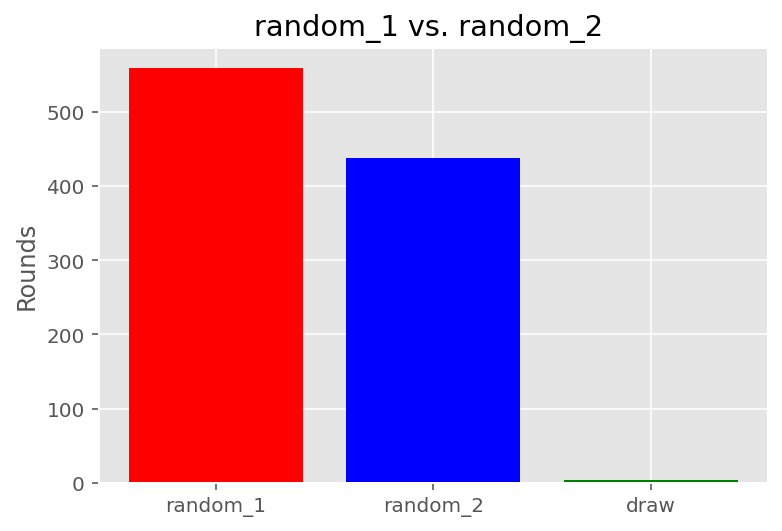

{'random_1': 559, 'random_2': 438, 'draw': 3}

1.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [77]:
%timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)),random_player, random_player, first_move_agent_name='random_1', second_move_agent_name='random_2', plot=True,N = 1000, number=4))

In [78]:
# Your code/ answer goes here.

## Task 3: Minimax Search with Alpha-Beta Pruning [4 points]

### Implement the search starting from a given board and specifying the player.



__Note:__ The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [79]:
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_ab_search(board, player = 1, number=4):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf, number)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return value, move

def max_value_ab(state, player, alpha, beta, number):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player,number)
    if DEBUG >= 2: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in available_actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta, number)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta, number):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player,number)
    if DEBUG >= 2: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in available_actions(state):
        v2, a2 = max_value_ab(result(state, opponent(player), a), player, alpha, beta, number)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

### In this part, I would use a smaller board(4 * 4) and changing the winning rule to connect 3 because the full board of connect 4 is time costly.

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [80]:
# test 1
# The player 'x' would choose 0 to win.
DEBUG = 1

def create_smaller_board_1(shape=(4,4)):
    board = empty_board(shape)
    board[-1,0] = 1
    board[-2,0] = 1
    board[-1,-2] = -1
    board[-1,-3] = -1
    return board

board = create_smaller_board_1()
show_board(board)

%timeit -n1 -r1 display(minimax_ab_search(board,player=1,number=3))

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ']
 ['x' 'o' 'o' ' ']]

Number of nodes searched: 103


(1, 0)

5.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [81]:
# test2 
# The player 'o' would choose 1 to win.
def create_smaller_board2(shape=(4,4)):
    """randomly create a board with round*2 pieces"""
    board = empty_board(shape)
    board[-1,0] = 1
    board[-2,0] = 1
    board[-3,0] = -1
    board[-1,-2] = -1
    board[-1,-3] = 1
    return board

board = create_smaller_board2()
show_board(board)

DEBUG = 1

%timeit -n1 -r1 display(minimax_ab_search(board,player=-1,number=3))

[[' ' ' ' ' ' ' ']
 ['o' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ']
 ['x' 'x' 'o' ' ']]

Number of nodes searched: 51


(1, 1)

3.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
# test3 
# the player 'x' would choose 2 to win
def create_smaller_board3(shape=(4,4)):
    board = empty_board(shape)
    board[3,0] = 1
    board[2,0] = 1
    board[1,0] = -1
    board[0,0] = -1
    board[3,1] = -1
    board[2,1] = 1
    board[1,1] = 1
    board[0,1] = -1
    board[3,2] = 1
    board[2,2] = -1
    board[1,2] = -1
    board[3,3] = 1
    # board[0,2] = -1
    return board

board = create_smaller_board3(shape=(4,4))
show_board(board)

DEBUG = 1

%timeit -n1 -r1 display(minimax_ab_search(board,player=1,number=3))

[['o' 'o' ' ' ' ']
 ['o' 'x' 'o' ' ']
 ['x' 'x' 'o' ' ']
 ['x' 'o' 'x' 'x']]

Number of nodes searched: 4


(1, 2)

923 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### This example is not so much straitforward to see why the player 'o' choose 0 to win. However, I try to calculate the processing after that and find that player 'o' will win since player 'x' could solely block it from winning at a maximum of 3 steps. After that, player 'x' can't stop player 'o' from winning the game.

In [83]:
# test4 
# The player 'o' may choose 2 to win.
def create_smaller_board4(shape=(4,4)):
    """randomly create a board with round*2 pieces"""
    board = empty_board(shape)
    board[-1,0] = 1
    board[-2,0] = 1
    board[-1,-1] = -1
    board[-1,-3] = -1
    return board

board = create_smaller_board4()
show_board(board)

DEBUG = 1

%timeit -n1 -r1 display(minimax_ab_search(board,player=-1,number=3))

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ']
 ['x' 'o' ' ' 'o']]

Number of nodes searched: 747


(1, 0)

36.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [84]:
# test5 
# The player 'o' may choose 1 to win.
def create_smaller_board5(shape=(4,4)):
    """randomly create a board with round*2 pieces"""
    board = empty_board(shape) 
    board[1,3] = -1
    board[2,3] = 1
    board[3,3] = 1
    board[3,3] = 1
    board[3,2] = 1
    board[2,2] = -1
    return board

board = create_smaller_board5()
show_board(board)

DEBUG = 1

%timeit -n1 -r1 display(minimax_ab_search(board,player=-1,number=3))

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'o']
 [' ' ' ' 'o' 'x']
 [' ' ' ' 'x' 'x']]

Number of nodes searched: 107


(1, 1)

5.81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

### In a 5 * 5 board of connect 3, it takes roughly 2 million nodes to make a move.

In [85]:
# board = empty_board(shape=(5,5))
# show_board(board)

# %timeit -n1 -r1 display(minimax_ab_search(board,player=-1,number=3))

### Move ordering

Describe and implement a simple move ordering strategy. How does this strategy influence the time it takes to 
make a move?

### It needs to be customized based on the size of (4 * 4) board and the winning rule of connect 3. I found the middle two columns should have more weights due to higher probability of achieving the connect of 3.

In [86]:
# Your code/ answer goes here.
def available_actions(board):
    """return possible actions as a vector ot indices"""
    actions = np.where(board[0,:] == 0)[0].tolist()

    priority = [1,2,2,1]
    priority = [priority[i] for i in actions]
    actions =[a for _,a in sorted(zip(priority,actions), reverse=True)]
    
    return actions

### For this example, there is a huge improvement after implementation of the move ordering. Without move ordering, it needs to search 747 nodes for making a decision, but with move ordering, it only needs to search 159 nodes for making a decision.

In [87]:
board = create_smaller_board4()
show_board(board)

DEBUG = 1

# available_actions(board)

%timeit -n1 -r1 display(minimax_ab_search(board,player=-1,number=3))

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ']
 ['x' 'o' ' ' 'o']]

Number of nodes searched: 159


(1, 2)

7.99 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [88]:
def minimax_ab_player(board, player = 1,number=4):
    value, action = minimax_ab_search(board, player, number)
    return action

### It seems that minimax search agent performs better than random agent.

In [89]:
# Your code/ answer goes here.
# DEBUG = 0
# print()
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(4,4)), minimax_ab_player, random_player, first_move_agent_name='alpha_beta_player_1', second_move_agent_name='random_player_1', plot=True, N = 10, number=3))

### Both are minimax search agent, the first move agent wins each rounds, which may denote that there is a first mover advantage.

In [90]:
# Your code/ answer goes here.
# DEBUG = 0
# print()
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(4,4)), minimax_ab_player, minimax_ab_player, first_move_agent_name='alpha_beta_player_1', second_move_agent_name='alpha_beta_player_2', plot=True, N = 1, number=3))

### I use a simple policy to level the weights of the middle three columns because it has a greater probability to form a connect of 4 over other columns.

In [91]:
from IPython.display import Image
Image(url='IMG_2261.jpg', width=400)

In [92]:
# A check for available actions.
def available_actions(board):
    """return possible actions as a vector of indices"""
    actions = np.where(board[0,:] == 0)[0].tolist()
    priority = [1,1,2,2,2,1,1]
    priority = [priority[i] for i in actions]
    actions =[a for _,a in sorted(zip(priority,actions), reverse=True)]
    return actions


## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

### This is my heuristic evaluation function.
1. For terminal states it is the utility.
2. For non-terminal states, I think each action making row/column/diagonal to have 3 pieces connected may have a higher probability to win. Hence, I would give weights for the try of this direction.

### 'eval_fun_c3' gives weights for possibility of forming 3 pieces connected in a row, column or diagonal. 'eval_fun_c2' gives weights for possibility of forming 2 pieces connected in a row, column or diagonal. 

In [93]:
# Your code/ answer goes here.
def get_score_by_number(board,player,number,baseline_bonus):
    board = board.copy()
    horizontal_sequence = np.ones((1,number),dtype=int)
    vertical_sequence = np.transpose(horizontal_sequence)
    diag1_sequence = np.eye(number,dtype=int)
    diag2_sequence = np.fliplr(diag1_sequence)
    detection_sequences = [
        horizontal_sequence,
        vertical_sequence,
        diag1_sequence,
        diag2_sequence
    ]
    score = 0
    for sequence in detection_sequences:
        if (convolve2d(board == player, sequence, mode="valid") == number).any(): 
            score += baseline_bonus
        elif (convolve2d(board == opponent(player), sequence, mode="valid") == number).any():
            score -= baseline_bonus
    return score

def eval_fun_c3(state, player = 1, number=4):    
    # terminal state?
    u = utility(state, player, number)
    if u is not None: return u, True
    
    score = get_score_by_number(board,player,number-1,0.02)
    
    return score, False

def eval_fun_c2(state, player=1, number=4):
        # terminal state?
    u = utility(state, player, number)
    if u is not None: return u, True
    
    score = get_score_by_number(board,player,number-2,0.01)
    
    return score, False

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [94]:
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def heuristic_minimax_ab_search(board, cutoff = None, player = 1, heuristic=eval_fun_c3, number=4):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0

    value, move = heuristic_max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff, heuristic, number)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return value, move

def heuristic_max_value_ab(state, player, alpha, beta, depth, cutoff, heuristic, number):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = heuristic(state, player, number)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in available_actions(state):
        v2, a2 = heuristic_min_value_ab(result(state, player, a), player, alpha, beta, depth + 1, cutoff, heuristic, number)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def heuristic_min_value_ab(state, player, alpha, beta, depth, cutoff, heuristic, number):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = heuristic(state, player, number)
    #if((cutoff is not None and depth >= cutoff) or terminal): 
    # always let the opponent make her move
    if(terminal): 
        if(terminal): alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in available_actions(state):
        v2, a2 = heuristic_max_value_ab(result(state, opponent(player), a), player, alpha, beta, depth + 1, cutoff, heuristic, number)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [95]:
#test1
# player 'x' may choose 3 to win
def create_board1(shape=(6,7)):
    board = empty_board(shape)
    board[5,0] = 1
    board[5,1] = 1
    board[5,2] = 1
    board[5,4] = -1
    board[5,5] = -1
    board[5,6] = -1
    return board

board = create_board1()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(heuristic_minimax_ab_search(board,cutoff=6,player=1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' 'x' 'x' ' ' 'o' 'o' 'o']]

Number of nodes searched (cutoff = 6): 894


(1, 3)

75.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [96]:
#test2
# player 'x' may choose 0 to win
def create_board2(shape=(6,7)):
    board = empty_board(shape)
    board[5,0] = 1
    board[4,0] = 1
    board[3,0] = 1
    board[5,4] = -1
    board[5,5] = -1
    board[5,6] = -1
    return board

board = create_board2()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(heuristic_minimax_ab_search(board,cutoff=4,player=1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' 'o' 'o' 'o']]

Number of nodes searched (cutoff = 4): 281


(1, 0)

26.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [97]:
#test3
# player 'x' may choose 3 to prevent player 'o' from winning.
def create_board3(shape=(6,7)):
    board = empty_board(shape)
    board[5,0] = 1
    board[4,0] = -1
    board[3,0] = 1
    board[5,4] = -1
    board[5,5] = -1
    board[5,6] = -1
    return board

board = create_board3()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(heuristic_minimax_ab_search(board,cutoff=4,player=1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['o' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' 'o' 'o' 'o']]

Number of nodes searched (cutoff = 4): 231


(-0.02, 3)

23.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [98]:
#test4
# player 'o' may choose 3 to win.
def create_board4(shape=(6,7)):
    board = empty_board(shape)
    board[5,0] = 1
    board[5,1] = 1
    board[5,2] = 1
    board[4,2] = -1
    board[4,0] = -1
    board[4,1] = -1
    board[3,0] = 1
    board[2,0] = -1
    board[2,1] = 1
    board[3,1] = -1
    board[5,4] = 1
    board[5,5] = -1
    board[5,6] = -1
    board[4,6] = 1
    return board

board = create_board4()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(heuristic_minimax_ab_search(board,cutoff=4,player=-1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['o' 'x' ' ' ' ' ' ' ' ' ' ']
 ['x' 'o' ' ' ' ' ' ' ' ' ' ']
 ['o' 'o' 'o' ' ' ' ' ' ' 'x']
 ['x' 'x' 'x' ' ' 'x' 'o' 'o']]

Number of nodes searched (cutoff = 4): 144


(1, 3)

14.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [99]:
#test5
# player 'x' may choose 4 to win.
def create_board5(shape=(6,7)):
    board = empty_board(shape)
    board[5,3] = 1
    board[5,6] = 1
    board[4,5] = -1
    board[5,5] = -1
    board[3,5] = 1
    board[5,4] = -1
    board[4,6] = -1
    board[3,6] = -1
    board[2,6] = 1
    board[1,6] = 1
    return board

board = create_board5()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(heuristic_minimax_ab_search(board,cutoff=4,player=1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' 'x']
 [' ' ' ' ' ' ' ' ' ' ' ' 'x']
 [' ' ' ' ' ' ' ' ' ' 'x' 'o']
 [' ' ' ' ' ' ' ' ' ' 'o' 'o']
 [' ' ' ' ' ' 'x' 'o' 'o' 'x']]

Number of nodes searched (cutoff = 4): 96


(1, 4)

10.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

### A low cutoff could ease the cost on each decision made. Since I have included the cost in the previous examples, I don't repeat here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [100]:
def heuristic_player_c4_e3(board, player = 1, cutoff=4, heuristic=eval_fun_c3, number=4):
    value, action = heuristic_minimax_ab_search(board, player=player, cutoff=cutoff, heuristic=heuristic,number=number)
    return action

def heuristic_player_c6_e3(board, player = 1, cutoff=6, heuristic=eval_fun_c3, number=4):
    value, action = heuristic_minimax_ab_search(board, player=player, cutoff=cutoff, heuristic=heuristic,number=number)
    return action

def heuristic_player_c4_e2(board, player = 1, cutoff=4, heuristic=eval_fun_c2, number=4):
    value, action = heuristic_minimax_ab_search(board, player=player, cutoff=cutoff, heuristic=heuristic,number=number)
    return action

def heuristic_player_c6_e2(board, player = 1, cutoff=6, heuristic=eval_fun_c2, number=4):
    value, action = heuristic_minimax_ab_search(board, player=player, cutoff=cutoff, heuristic=heuristic,number=number)
    return action

def heuristic_player_c10_e2(board, player = 1, cutoff=10, heuristic=eval_fun_c2, number=4):
    value, action = heuristic_minimax_ab_search(board, player=player, cutoff=cutoff, heuristic=heuristic,number=number)
    return action

### In terms of solely ten examples, I can't draw a conclusion of which agent is better. Instead, I have a guess that the agent with lower cutoff will perform better on given weights of greater probability of connect 3 while the agent with higher cutoff will perform better on given weights of greater probability of connect 2.

In [101]:
# Your code/ answer goes here.
# DEBUG = 0
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c4_e3, heuristic_player_c4_e2, first_move_agent_name='heuristic_c4_e3', second_move_agent_name='heuristic_c4_e2', plot=True, N = 10, number=4))

# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c4_e3, heuristic_player_c6_e3, first_move_agent_name='heuristic_c4_e3', second_move_agent_name='heuristic_c6_e3', plot=True, N = 10, number=4))

# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c4_e2, heuristic_player_c6_e3, first_move_agent_name='heuristic_c4_e2', second_move_agent_name='heuristic_c6_e3', plot=True, N = 10, number=4))

# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c6_e2, heuristic_player_c6_e3, first_move_agent_name='heuristic_c6_e2', second_move_agent_name='heuristic_c6_e3', plot=True, N = 10, number=4))

In [102]:
# Your code/ answer goes here.

## Challenge task [+ 1 bonus point]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlos Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [103]:
# Your code/ answer goes here.

### 'playouts_heuristic' simulates N actions based on heuristic search agent with cutoff 2 and pick the action with the highest average utility. 'playout_random' simulates N actions based on random agent and pick the action with the highest average utility.


In [104]:
def playout_heuristic(state, action, player = 1, number=4):
    """Perfrom a random playout starting with the given action on the fiven board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = opponent(player)
    global DEBUG
    a = DEBUG

    while(True):
        # reached terminal state?
        u = utility(state, player, number)
        if u is not None: return(u)
        
        DEBUG = 0# stop debugging because it may generate lots of outputs when I use pure Monte Carlo Search
        # we use a random playout policy
        a = heuristic_player_c6_e3(state, player, cutoff=2, heuristic=eval_fun_c3, number=4)
        DEBUG = a
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = opponent(current_player)
    

def playout_random(state, action, player = 1, number=4):
    """Perfrom a random playout starting with the given action on the fiven board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = opponent(player)
    
    while(True):
        # reached terminal state?
        u = utility(state, player, number)
        if u is not None: return(u)
        
        # we use a random playout policy
        a = np.random.choice(available_actions(state))
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = opponent(current_player)

def playouts_heuristic(board, action, player = 1, number=4, N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout_heuristic(board, action, player, number) for i in range(N) ]

def playouts_random(board, action, player = 1, number=4, N = 100):
    """Perform N playouts following the given action for the given board."""
    return [ playout_random(board, action, player, number) for i in range(N) ]

In [105]:
DEBUG = 1

def pmcs(board, N = 100, player = 1, number=4, playout_eval=playouts_random):
    """Pure Monte Carlo Search. Returns the action that has the largest average utility.
    The N playouts are evenly divided between the possible actions."""
    global DEBUG
    
    actions = available_actions(board)
    n = math.floor(N/len(actions))
    if DEBUG >= 1: print(f"Actions: {actions} ({n} playouts per actions)")
    
    ps = { i:np.mean(playout_eval(board, i, player, number=number, N = n)) for i in actions }
    if DEBUG >= 1: display(ps)
        
    action = max(ps, key=ps.get)
    return action

In [106]:
#test1
# player 'x' would choose 3 to win
board = create_board1()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=1))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' 'x' 'x' ' ' 'o' 'o' 'o']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 0.2857142857142857,
 3: 1.0,
 2: 0.14285714285714285,
 6: 0.0,
 5: 0.14285714285714285,
 1: 0.42857142857142855,
 0: -0.5714285714285714}

3

34.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [107]:
#test2
# player 'x' would choose 0 to win
board = create_board2()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=1, playout_eval=playouts_random))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' 'o' 'o' 'o']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: -0.2857142857142857,
 3: 0.7142857142857143,
 2: -0.14285714285714285,
 6: -0.2857142857142857,
 5: 0.5714285714285714,
 1: 0.14285714285714285,
 0: 1.0}

0

42.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [108]:
#test3
# player 'o' would choose 3 to win
board = create_board3()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=-1,playout_eval=playouts_random))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' ' ' ' ' ' ']
 ['o' ' ' ' ' ' ' ' ' ' ' ' ']
 ['x' ' ' ' ' ' ' 'o' 'o' 'o']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 0.5714285714285714,
 3: 1.0,
 2: 0.42857142857142855,
 6: 0.7142857142857143,
 5: 0.2857142857142857,
 1: 0.42857142857142855,
 0: 0.5714285714285714}

3

66.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [109]:
#test4
# player 'o' would choose 3 to win
board = create_board4()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=-1,playout_eval=playouts_random))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['o' 'x' ' ' ' ' ' ' ' ' ' ']
 ['x' 'o' ' ' ' ' ' ' ' ' ' ']
 ['o' 'o' 'o' ' ' ' ' ' ' 'x']
 ['x' 'x' 'x' ' ' 'x' 'o' 'o']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 0.0,
 3: 1.0,
 2: 0.0,
 6: -0.14285714285714285,
 5: 0.14285714285714285,
 1: 0.0,
 0: -0.2857142857142857}

3

32.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [110]:
#test5
# player 'x' would choose 4 to win
board = create_board5()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=1,playout_eval=playouts_random))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' 'x']
 [' ' ' ' ' ' ' ' ' ' ' ' 'x']
 [' ' ' ' ' ' ' ' ' ' 'x' 'o']
 [' ' ' ' ' ' ' ' ' ' 'o' 'o']
 [' ' ' ' ' ' 'x' 'o' 'o' 'x']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 1.0,
 3: 1.0,
 2: 0.42857142857142855,
 6: 0.2857142857142857,
 5: 0.42857142857142855,
 1: 0.7142857142857143,
 0: 0.7142857142857143}

4

49.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [111]:
def pmcs10_player(board, player = 1, number=4):
    action = pmcs(board, N = 10, player = player, number=number,playout_eval=playouts_random)
    return action

def pmcs100_player(board, player = 1, number=4):
    action = pmcs(board, N = 100, player = player, number=number,playout_eval=playouts_random)
    return action

def pmcs1000_player(board, player = 1, number=4):
    action = pmcs(board, N = 1000, player = player, number=number,playout_eval=playouts_random)
    return action

def pmcs3000_player(board, player = 1, number=4):
    action = pmcs(board, N = 3000, player = player, number=number,playout_eval=playouts_random)
    return action

### My heuristic agent has an advantage over pmcs10 agent.

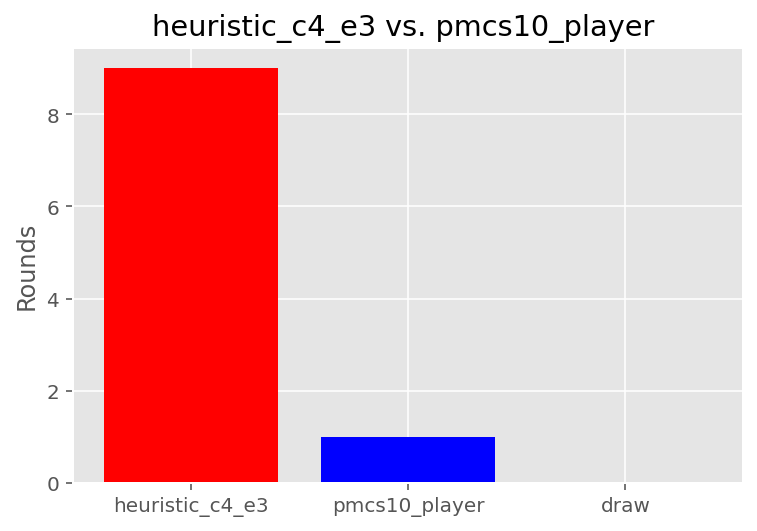

{'heuristic_c4_e3': 9, 'pmcs10_player': 1, 'draw': 0}

2.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [112]:
DEBUG = 0
print()
%timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c4_e3, pmcs10_player, first_move_agent_name='heuristic_c4_e3', second_move_agent_name='pmcs10_player', plot=True, N = 10, number=4))

### My heruistic agent still has advantage over the pmcs100 agent.

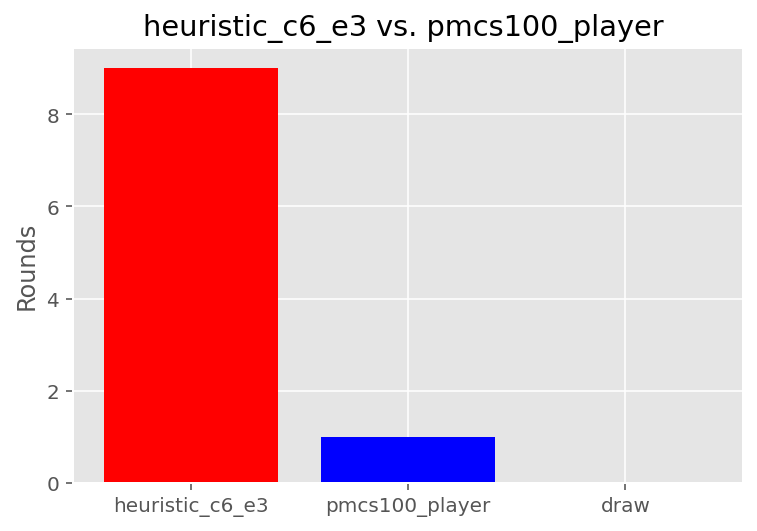

{'heuristic_c6_e3': 9, 'pmcs100_player': 1, 'draw': 0}

16.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [113]:
%timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c6_e3, pmcs100_player, first_move_agent_name='heuristic_c6_e3', second_move_agent_name='pmcs100_player', plot=True, N = 10, number=4))

### It seems pmcs1000 improve a bit over previous pmcs agent, so I think the pmcs agent played more rounds will have a better performance.

In [114]:
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c6_e3, pmcs1000_player, first_move_agent_name='heuristic_c6_e3', second_move_agent_name='pmcs1000_player', plot=True, N = 10, number=4))

In [115]:
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), heuristic_player_c6_e3, pmcs3000_player, first_move_agent_name='heuristic_c6_e3', second_move_agent_name='pmcs3000_player', plot=True, N = 10, number=4))

### Best First Move

How would you determine what the best first move is? You can use Pure Monte Carlo Search or any algorithms 
that you have implemented above.

### I would use Pure Monte Carlo Search with random playouts to determine the first move because it's faster.

In [116]:
board = empty_board()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=1,playout_eval=playouts_heuristic))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 1.0, 3: 0.0, 2: 0.0, 6: 0.0, 5: 0.0, 1: 0.0, 0: -1.0}

4

3.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [117]:
board = empty_board()
show_board(board)

DEBUG = 1
%timeit -n1 -r1 display(pmcs(board,player=1,playout_eval=playouts_random))

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]

Actions: [4, 3, 2, 6, 5, 1, 0] (14 playouts per actions)


{4: 0.14285714285714285,
 3: 0.42857142857142855,
 2: 0.0,
 6: -0.42857142857142855,
 5: 0.14285714285714285,
 1: 0.2857142857142857,
 0: -0.14285714285714285}

3

102 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [118]:
# Your code/ answer goes here.

In [119]:
# %timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), pmcs1000_player, pmcs1000_player, first_move_agent_name='heuristic_c6_e3', second_move_agent_name='pmcs1000_player', plot=True, N = 10, number=4))

In [120]:
import Sabrina

In [ ]:
Sabrina.DEBUG = 0
DEBUG = 0
%timeit -n 1 -r 1 display(play(lambda: empty_board(shape=(6,7)), pmcs1000_player, Sabrina.ucb1_1000_player_with_first_moves, first_move_agent_name='liangchao.agent', second_move_agent_name='Sabrina.agent', plot=True, N = 10, number=4))